In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Persiapan Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

documents_folder = "/content/drive/My Drive/Semester 2/Deep Learning/"
# Use pd.read_json to read data from the JSON file
df = pd.read_csv(documents_folder+"dataset.csv")
print(len(df))
df.head()

4748


,slang,formal
0,Akoh lagi syedih,Aku sedang sedih
1,Gw males banget ngerjain tugas ini,Saya malas sekali mengerjakan tugas ini
2,Elo mau ikut nongki gak?,Kamu mau ikut nongkrong tidak?
3,Nggak usah lebay deh,Tidak usah berlebihan
4,Udah kelar belom kerjaan lo?,Sudah selesai belum pekerjaanmu?


In [4]:
# Pisahkan input dan target
# Preprocessing dasar
df['slang'] = df['slang'].str.lower().str.replace('[^\w\s]', '', regex=True) # Added regex=True
df['formal'] = df['formal'].str.lower().str.replace('[^\w\s]', '', regex=True) # Added regex=True

raw_src = df['slang']
# Add start and end tokens to the target sentences
raw_tgt = '[start] ' + df['formal'] + ' [end]'


# Split train-validation
src_train, src_val, tgt_train, tgt_val = train_test_split(
    raw_src, raw_tgt, test_size=0.2, random_state=42)

#Preprocessing & Tokenisasi

In [41]:
# Hyperparameter
MAX_SEQ_LENGTH = 10
VOCAB_SIZE = 500
BATCH_SIZE = 1
EPOCHS = 20

In [28]:
# Buat tokenizer
# Ensure `standardize` does not remove our added [start] and [end] tokens
# Also increase MAX_SEQ_LENGTH for the target to accommodate [start] and [end]
src_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation', # This will remove our [start] and [end] if not careful
    output_sequence_length=MAX_SEQ_LENGTH
)

# A custom standardization function to keep [start] and [end]
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    # Remove punctuation except for []
    cleaned_text = tf.strings.regex_replace(lowercase, '[^\w\s\[\]]', '')
    return cleaned_text

tgt_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=custom_standardization, # Use custom standardization
    output_sequence_length=MAX_SEQ_LENGTH + 2 # +2 for [start] and [end]
)


# Adapt tokenizer
src_tokenizer.adapt(src_train)
tgt_tokenizer.adapt(tgt_train)

# Fungsi preprocessing
def preprocess_text(src, tgt):
    src = src_tokenizer(src)
    # The target includes [start] and [end].
    # tgt_in should be [start]...token_n, tgt_out should be token_1...[end]
    tgt_tokens = tgt_tokenizer(tgt)
    tgt_in = tgt_tokens[:, :-1] # Exclude the last token ([end])
    tgt_out = tgt_tokens[:, 1:] # Exclude the first token ([start])
    return (src, tgt_in), tgt_out

# Buat dataset
train_dataset = tf.data.Dataset.from_tensor_slices((src_train, tgt_train))
# Apply batch before map
train_dataset = train_dataset.batch(BATCH_SIZE).map(preprocess_text).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((src_val, tgt_val))
# Apply batch before map
val_dataset = val_dataset.batch(BATCH_SIZE).map(preprocess_text).prefetch(tf.data.AUTOTUNE)

# Check if [start] and [end] are in the vocabulary
print("[start] in tgt_vocab:", '[start]' in tgt_tokenizer.get_vocabulary())
print("[end] in tgt_vocab:", '[end]' in tgt_tokenizer.get_vocabulary())
print("Sample of tgt_train:", tgt_train.head().values)

[start] in tgt_vocab: True
[end] in tgt_vocab: True
Sample of tgt_train: ['[start] kamu selalu membuat aku lengkap banget [end]'
 '[start] jangan lupa tersenyum ya [end]'
 '[start] ia sungguh mengapresiasi setiap perjuangan dan pengorbanan yang telah engkau curahkan segenap hati [end]'
 '[start] kamu kemarin ke mana [end]' '[start] saya bangga padamu [end]']


#Arsitektur Model

In [29]:
import tensorflow as tf
import numpy as np

# ===========================================
# 1. Multi-Head Attention (Kelas Terpisah)
# ===========================================
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        # Scaled Dot-Product Attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            # Perhatikan penambahan mask yang di-broadcast
            scaled_attention += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention, axis=-1)
        output = tf.matmul(attention_weights, v)

        # Concatenate Heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))

        return self.dense(output)

# ===========================================
# 2. Encoder (Kelas Terpisah)
# ===========================================
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    # training dan mask adalah parameter untuk call
    def call(self, x, training=True, mask=None): # Set training to True by default
        # Self Attention
        attn_output = self.mha(x, x, x, mask) # x, x, x untuk self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # Feed Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        # Inisialisasi PositionalEncoding dengan 'position' dan 'd_model'
        self.pos_encoding = PositionalEncoding(pe_input, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    # Add training as keyword argument for consistency
    def call(self, x, training=True, mask=None): # Set training to True by default
        seq_len = tf.shape(x)[1]

        # Penambahan positional encoding ke embedding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Skalakan embedding
        x = self.pos_encoding(x) # Tambahkan positional encoding
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # Pass training as keyword argument to EncoderLayer
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x # Output dari encoder adalah representasi kaya konteks

# ===========================================
# 3. Decoder (Kelas Terpisah)
# ===========================================
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads) # Masked self-attention
        self.mha2 = MultiHeadAttention(d_model, num_heads) # Encoder-decoder attention
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    # training, look_ahead_mask, dan padding_mask adalah parameter untuk call
    def call(self, x, enc_output, training=True, look_ahead_mask=None, padding_mask=None): # Set training to True by default
        # Masked Self Attention (menggunakan look_ahead_mask)
        attn1 = self.mha1(x, x, x, look_ahead_mask) # query, key, value dari output decoder sebelumnya
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # Add & Norm

        # Encoder-Decoder Attention (menggunakan padding_mask dari encoder)
        # query dari output masked self-attention, key dan value dari output encoder
        attn2 = self.mha2(
            out1, enc_output, enc_output, padding_mask # perhatikan urutan q, k, v
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1) # Add & Norm

        # Feed Forward
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(ffn_output + out2) # Add & Norm

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        # Inisialisasi PositionalEncoding dengan 'position' dan 'd_model'
        self.pos_encoding = PositionalEncoding(pe_target, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    # Add training as keyword argument for consistency
    def call(self, x, enc_output, training=True, look_ahead_mask=None, padding_mask=None): # Set training to True by default
        seq_len = tf.shape(x)[1]

        # Penambahan positional encoding ke embedding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Skalakan embedding
        x = self.pos_encoding(x) # Tambahkan positional encoding
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # Masukkan kedua mask ke setiap decoder layer, pass training as keyword argument
            x = self.dec_layers[i](x, enc_output, training=training,
                                  look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        return x # Output dari decoder stack

# ===========================================
# 4. Positional Encoding
# ===========================================
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def positional_encoding(self, position, d_model):
        # Menghitung sudut radian untuk setiap posisi dan setiap dimensi
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)//2) / np.float32(d_model)))

        # Terapkan sin pada posisi genap
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Terapkan cos pada posisi ganjil
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        # Tambahkan dimensi batch dan ubah ke tipe float32 Tensor
        return tf.cast(angle_rads[np.newaxis, ...], tf.float32)

    # Input x memiliki shape (batch_size, seq_len, d_model)
    def call(self, x):
        # Tambahkan positional encoding ke input
        # Ambil positional encoding hanya sepanjang seq_len input
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ===========================================
# 5. Transformer Model Utama
# ===========================================
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        # Inisialisasi encoder dan decoder, berikan pe_input dan pe_target
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        # Layer output akhir
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    # Metode untuk membuat mask
    def create_masks(self, src, tgt):
        # Mask padding untuk encoder (berdasarkan src). Digunakan di encoder self-attention
        enc_padding_mask = tf.cast(tf.math.equal(src, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        # Mask padding untuk decoder (berdasarkan tgt). Digunakan di decoder self-attention dan encoder-decoder attention
        # Catatan: Asumsikan nilai padding adalah 0
        dec_padding_mask = tf.cast(tf.math.equal(tgt, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        # Mask look-ahead untuk decoder (untuk masked self-attention pertama di decoder)
        look_ahead_mask = 1 - tf.linalg.band_part(
            tf.ones((tf.shape(tgt)[1], tf.shape(tgt)[1])), -1, 0)

        # Gabungkan mask look-ahead dan mask padding untuk masked self-attention di decoder
        combined_mask = tf.maximum(dec_padding_mask, look_ahead_mask)

        # Mask padding untuk encoder-decoder attention (berdasarkan src). Digunakan di MHA kedua decoder
        # Mask ini memastikan decoder tidak memperhatikan token padding di input encoder
        encoder_decoder_padding_mask = tf.cast(tf.math.equal(src, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]


        # Kembalikan tiga jenis mask yang dibutuhkan
        return enc_padding_mask, combined_mask, encoder_decoder_padding_mask

    # Metode call untuk forward pass
    def call(self, inputs, training=True):
        src, tgt = inputs
        # Buat semua mask yang dibutuhkan
        enc_padding_mask, combined_mask, encoder_decoder_padding_mask = self.create_masks(src, tgt)

        # Forward pass melalui encoder
        # Pass training as keyword argument
        enc_output = self.encoder(src, training=training, mask=enc_padding_mask)

        # Forward pass melalui decoder
        # Pass training as keyword argument
        dec_output = self.decoder(
            tgt, enc_output, training=training,
            look_ahead_mask=combined_mask, # Mask gabungan untuk masked self-attention
            padding_mask=encoder_decoder_padding_mask # Mask padding untuk encoder-decoder attention
        )

        # Layer output akhir
        final_output = self.final_layer(dec_output)

        return final_output # Output akhir adalah probabilitas distribusi kata target

#Training & Evaluasi

In [33]:
# Hyperparameter
NUM_LAYERS = 2
D_MODEL = 64
NUM_HEADS = 4
DFF = 256
INPUT_VOCAB_SIZE = 500
TARGET_VOCAB_SIZE = 500
MAX_POSITION_ENCODING = 500

# Inisialisasi model
transformer = Transformer(
    NUM_LAYERS, D_MODEL, NUM_HEADS, DFF,
    INPUT_VOCAB_SIZE, TARGET_VOCAB_SIZE,
    MAX_POSITION_ENCODING, MAX_POSITION_ENCODING
)
# Kompilasi model
transformer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [49]:
# Callback untuk early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Training
history = transformer.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stop]
)

Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8578 - loss: 0.5404 - val_accuracy: 0.8013 - val_loss: 1.0278
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8636 - loss: 0.5208 - val_accuracy: 0.8010 - val_loss: 1.0394


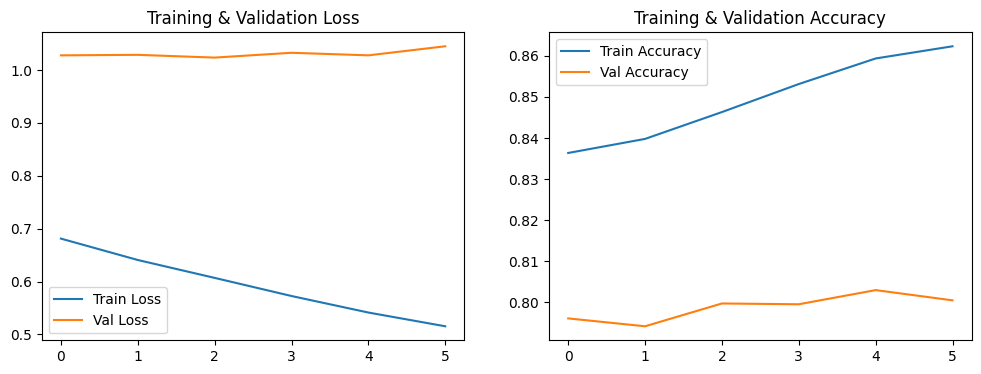

In [43]:
# ===========================================
# 5. Visualisasi Hasil
# ===========================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

In [44]:
transformer.summary()

Model: "transformer_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_7 (Encoder)             │ ?                      │       131,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_7 (Decoder)             │ ?                      │       165,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, None, 500)      │        32,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 989,918 (3.78 MB)

 Trainable params: 329,972 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 659,946 (2.52 MB)

In [45]:
def normalize_text(input_text, model, src_tokenizer, tgt_tokenizer, max_length=MAX_SEQ_LENGTH):
    # Tokenisasi input
    processed_src = src_tokenizer([input_text])

    # Encode input menggunakan encoder
    encoder_output = model.encoder(processed_src, training=False)

    # Inisialisasi decoder dengan token [start]
    start_token = tgt_tokenizer.get_vocabulary().index('[start]')  # Ganti dengan token yang sesuai
    end_token = tgt_tokenizer.get_vocabulary().index('[end]')      # Ganti dengan token yang sesuai
    decoder_input = tf.expand_dims([start_token], 0)  # Bentuk (1, 1)

    # Generate token step-by-step
    for _ in range(max_length):
        # Buat mask
        enc_padding_mask, combined_mask, enc_dec_padding_mask = model.create_masks(
            processed_src, decoder_input
        )

        # Prediksi token berikutnya
        predictions = model.decoder(
            decoder_input, encoder_output, training=False,
            look_ahead_mask=combined_mask,
            padding_mask=enc_dec_padding_mask
        )
        predictions = model.final_layer(predictions)

        # Ambil token dengan probabilitas tertinggi
        predicted_id = tf.argmax(predictions[:, -1, :], axis=-1)

        # Tambahkan ke decoder input
        decoder_input = tf.concat([decoder_input, [predicted_id]], axis=-1)

        # Hentikan jika prediksi adalah [end]
        if predicted_id == end_token:
            break

    # Konversi token IDs ke teks
    generated_ids = decoder_input.numpy()[0]
    # Filter token spesial dan padding
    generated_tokens = [tgt_tokenizer.get_vocabulary()[i] for i in generated_ids
                        if i not in [start_token, end_token, 0]]

    return ' '.join(generated_tokens)

In [47]:
# Contoh teks input
input_text = "TBL TBL TBL, sarem banget filmnya"

# Normalisasi teks
normalized_text = normalize_text(
    input_text,
    transformer,
    src_tokenizer,
    tgt_tokenizer
)

print("Input Informal:", input_text)
print("Output Formal:", normalized_text)

Input Informal: TBL TBL TBL, sarem banget filmnya
Output Formal: takut sekali [UNK] sekali filmnya
